


## Notebook runs Bertweet(English) for TASK-1 and TASK-2

In [ ]:
pip install contractions emoji simpletransformers

In [ ]:
import pandas as pd
import numpy as np
import string
import regex as re
import contractions
import emoji
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel, ClassificationArgs
import seaborn as sns
import matplotlib.pyplot as plt   
import wandb
import logging
from statistics import mean, mode

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
def expand_hashtags ( sentences):
        hashtag_pattern = re.compile (r'#([\p{L}0-9\_]+)')
        return sentences.apply (lambda x: re.sub (hashtag_pattern, lambda match: camel_case_split (match.group (1)), x))

def camel_case_split ( identifier):
        # link https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python/29920015
        
        matches = re.finditer ('.+?(?:(?<=\p{Ll})(?=\p{Lu})|(?<=\p{Lu})(?=\p{Lu}\p{Ll})|[0-9]+|$)', identifier)
        return ' '.join ([m.group (0) for m in matches])

In [ ]:
def expand_contractions(text):
    return contractions.fix(text)

In [ ]:
def remove_links(s):
    removeLinksPattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.DOTALL)
    tmp = re.sub(removeLinksPattern, ' ', s)#, flags = re.DOTALL)
    return tmp 

In [ ]:
def remove_mentions(text):
    begining_mentions_pattern = re.compile (r"^(@[A-Za-z0-9\_]+\s?)+")
    middle_mentions_pattern = re.compile (r'(?<!\b)@([A-Za-z0-9\_]+)\b(?<!user)')
    txt = text.apply (lambda x: re.sub (begining_mentions_pattern, '', x))
    return txt

In [ ]:
def remove_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.sub(percents_pattern, ' ', x))#   re.findall(percents_pattern, text)

def check_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.findall(percents_pattern,  x))#   re.findall(percents_pattern, text)

In [ ]:
def remove_digits (text, replace = '[NUMERO]'):
        digits_pattern = re.compile (r"\b(\d+[\.,]?\d*|\d{2}[AP]M)\b")
        return text.apply (lambda x: re.sub (digits_pattern, replace, x))

In [ ]:
# link https://stackoverflow.com/questions/24893977/whats-the-best-way-to-regex-replace-a-string-in-python-but-keep-its-case
def replace_keep_case (word, replacement, text):
    def func (match):
        g = match.group ()
        if g.islower (): return replacement.lower ()
        if g.istitle (): return replacement.title ()
        if g.isupper (): return replacement.upper ()
        return replacement
    return re.sub (word, func, text)

def remove_elongations (text):
        laughs_pattern = re.compile (r'(?i)\b(mua)?j[ja]+a?\b')
        # Remove laughs
        txt = text.apply (lambda x: re.sub (laughs_pattern, 'jajaja', x))

        
        # Remove exclamatory and interrogative
        for character in ['!', '¡', '?', '¿']:
            pattern = re.compile ('\\' + character + '{2,}')
            txt = txt.apply (lambda x: re.sub (pattern, character, x))
        
        # Add (.)\1{2,}|[aá]{2,}|[eé]{2,}|[ií]{2,}|[oó]{2,}|[uú]{2,})
        elongation_pattern = re.compile (r'(.)\1{2,}')
        # Remove letters longer than 2
        txt = txt.apply (lambda x: re.sub (elongation_pattern, r'\1', x))
        
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[aá]{2,}'), "á", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[eé]{2,}'), "é", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[ií]{2,}'), "í", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[oó]{2,}'), "ó", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[uú]{2,}'), "ú", x))
        return txt

In [ ]:
def remove_emojis (text):
        return text.apply (lambda x: emoji.get_emoji_regexp ().sub (u'', x))

In [ ]:
def remove_quotations (text):
        quotations_pattern = r'["“”\'«»‘’]'
        return text.replace (to_replace = quotations_pattern, value = '', regex = True)

In [ ]:
def remove_punctuation (text):
    punctuation_pattern = re.compile ("[" + re.escape(string.punctuation) + "]")
    #print(punctuation_pattern)
    punc = text.apply (lambda x: re.findall(punctuation_pattern,  x))
    #print(punc)
    return text.apply (lambda x: re.sub (punctuation_pattern, '', x))

In [ ]:
def preprocessData(text):
  txt = expand_hashtags(text)
  txt = txt.apply(lambda x: expand_contractions(x))
  txt = txt.apply(lambda x: remove_links(x))
  txt = remove_mentions(txt)
  txt = remove_percentages(txt)
  txt = remove_digits(txt)
  txt = remove_elongations(txt)
  txt = remove_emojis(txt)
  txt = txt.str.lower()
  txt = remove_quotations(txt)
  txt = remove_punctuation(txt)
  txt = txt.apply(lambda x: x.strip())
  return txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/sexism_detection/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/sexism_detection/EXIST2021_test_labeled.tsv", sep="\t")

In [ ]:
# train_data = train_data.drop(["test_case", "source", "language", "id"], axis = 1)

### **Preprocessing**

In [ ]:
train_data.text = preprocessData(train_data.text)
test_data.text = preprocessData(test_data.text)

In [ ]:
train_data.head(5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,she calls herself antifeminazi how about shut ...,sexist,ideological-inequality
1,EXIST2021,2,twitter,en,now back to these women the brave and the beau...,non-sexist,non-sexist
2,EXIST2021,3,twitter,en,wow your skirt is very short what is it is len...,sexist,objectification
3,EXIST2021,4,twitter,en,incredible beautifulbut i laughed so much whe...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


In [ ]:
test_data.head(5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,6978,gab,en,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist
1,EXIST2021,6979,twitter,en,he sounds like as ass and very condescending,non-sexist,non-sexist
2,EXIST2021,6980,twitter,en,lol this behavior of not letting men tell you ...,sexist,ideological-inequality
3,EXIST2021,6981,twitter,en,rightsi mean yeah most women especially the wo...,sexist,ideological-inequality
4,EXIST2021,6982,twitter,en,the jack manifold appreciation i am séing is o...,non-sexist,non-sexist


### Creating binary labels for task - 1 for both train and test data

In [ ]:
encoder_task1 = LabelBinarizer()
encoder_task1.fit(train_data['task1'])
transformed = encoder_task1.transform(train_data['task1'])
train_data['label-task-1'] = pd.DataFrame(transformed)

encoder_task1.fit(test_data['task1'])
transformed = encoder_task1.transform(test_data['task1'])
test_data['label-task-1'] = pd.DataFrame(transformed)

In [ ]:
train_data_english = train_data[train_data.language != 'es']
test_data_english = test_data[test_data.language != 'es']

In [ ]:
print(train_data_english.shape, test_data_english.shape)


(3436, 8) (2208, 8)


### Class size in train data

In [ ]:
train_data_english.groupby(['task1']).size()

task1
non-sexist    1800
sexist        1636
dtype: int64

### Class size in test data

In [ ]:
test_data_english.groupby(['task1']).size()

task1
non-sexist    1050
sexist        1158
dtype: int64

### dropping useless columns and split into train and eval


In [ ]:
train_data_english = train_data_english.drop(["test_case", "source", "language", "id"], axis = 1)
eval_data_english = train_data_english.iloc[:1000,:]
# train_data_english = train_data_english.iloc[1000:,:]
test_data_english = test_data_english.drop(["test_case", "source", "language", "id"], axis = 1)

In [ ]:
train_data_english.head(5)

,text,task1,task2,label-task-1
0,she calls herself antifeminazi how about shut ...,sexist,ideological-inequality,1
1,now back to these women the brave and the beau...,non-sexist,non-sexist,0
2,wow your skirt is very short what is it is len...,sexist,objectification,1
3,incredible beautifulbut i laughed so much whe...,non-sexist,non-sexist,0
4,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,0


In [ ]:
test_data_english.head(5)

,text,task1,task2,label-task-1
0,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist,0
1,he sounds like as ass and very condescending,non-sexist,non-sexist,0
2,lol this behavior of not letting men tell you ...,sexist,ideological-inequality,1
3,rightsi mean yeah most women especially the wo...,sexist,ideological-inequality,1
4,the jack manifold appreciation i am séing is o...,non-sexist,non-sexist,0


In [ ]:
def display_classification_stats(result):
  confusion_matrix = np.zeros((2,2))
  confusion_matrix[0][0] = result['tn']
  confusion_matrix[0][1] = result['fp']
  confusion_matrix[1][0] = result['fn']
  confusion_matrix[1][1] = result['tp']


  precision =  result['tp'] / ( result['tp'] + result['fp'] )
  recall = result['tp'] / ( result['tp'] + result['fn'] )
  F_score =  2 * precision * recall / (precision + recall)
  accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1])/np.sum(confusion_matrix)
  print("ACCURACY  : ", accuracy)
  print("PRECISION : ", precision)
  print("RECALL    : ", recall)
  print("F1        : ", F_score)

  print(confusion_matrix)
  ax= plt.subplot()
  sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['non-sexism', 'sexism']); ax.yaxis.set_ticklabels(['non-sexism', 'sexism']);

## Task1

In [ ]:
sweep_config = {
    "name": "vanilla-sweep-batch-16",
    "method": "bayes",
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 1, "max": 5},
        "learning_rate": {"min": 1e-6, "max": 5e-5},
    },
    "early_terminate": {"type": "hyperband", "min_iter": 6,},
}

sweep_id = wandb.sweep(sweep_config, project="EXIST BERTWEET - Hyperparameter Optimization 3")
# sweep_id = "4bz1p9xc"
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
model_args = ClassificationArgs()
model_args.learning_rate = 5e-5
model_args.max_seq_length = 128
model_args.num_train_epochs = 3
model_args.overwrite_output_dir = True
model_args.train_batch_size = 16
model_args.evaluate_during_training = True
model_args.evaluate_during_training_silent = False
model_args.evaluate_during_training_steps = 1000
model_args.wandb_project = "EXIST BERTWEET - Hyperparameter Optimization 3"

In [ ]:
model_bertweet_task1_english = ClassificationModel('bertweet', 'vinai/bertweet-base', weight=[1,1.1], use_cuda=True, args=model_args)

In [ ]:
def train():
    # Initialize a new wandb run
    wandb.init(resume)

    # Create a TransformerModel
    model = ClassificationModel('bertweet', 'vinai/bertweet-base', weight=[1,1.1], use_cuda=True, args=model_args, sweep_config=wandb.config)

    # Train the model
    model.train_model(train_data_english[['text','label-task-1']], eval_df=eval_data_english[['text','label-task-1']], accuracy=accuracy_score)

    # Sync wandb
    wandb.join()

wandb.agent(sweep_id, train, project="EXIST BERTWEET - Hyperparameter Optimization 3")

In [ ]:
# model_bertweet_task1_english = ClassificationModel( 'bertweet', 'vinai/bertweet-base', args={'train_batch_size':4, 'learning_rate': 4e-5, 'num_train_epochs': 2, 'max_seq_length': 128, 'overwrite_output_dir': True})

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [ ]:
model_bertweet_task1_english.train_model(train_data_english[['text','label-task-1']],accuracy=accuracy_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3436 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/859 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/859 [00:00<?, ?it/s]

(1718, 0.5937544564012877)

In [ ]:
result, model_outputs, wrong_predictions = model_bertweet_task1_english.eval_model(train_data_english[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3436 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/430 [00:00<?, ?it/s]

In [ ]:
result

{'mcc': 0.6927701206153956,
 'tp': 1520,
 'tn': 1364,
 'fp': 436,
 'fn': 116,
 'auroc': 0.9112136647650095,
 'auprc': 0.8854376121199103,
 'eval_loss': 0.4251402078672897}

ACCURACY  :  0.8393480791618161
PRECISION :  0.7770961145194274
RECALL    :  0.9290953545232273
F1        :  0.8463251670378619
[[1364.  436.]
 [ 116. 1520.]]


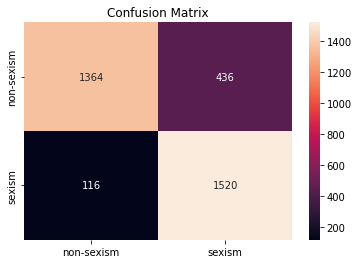

In [ ]:
display_classification_stats(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2208 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/276 [00:00<?, ?it/s]

ACCURACY  :  0.7667572463768116
PRECISION :  0.7369196757553427
RECALL    :  0.8635578583765112
F1        :  0.7952286282306162
[[ 693.  357.]
 [ 158. 1000.]]


{'mcc': 0.5372283317090302,
 'tp': 1000,
 'tn': 693,
 'fp': 357,
 'fn': 158,
 'auroc': 0.8263130191627601,
 'auprc': 0.8145523199052823,
 'eval_loss': 0.6243667395218558}

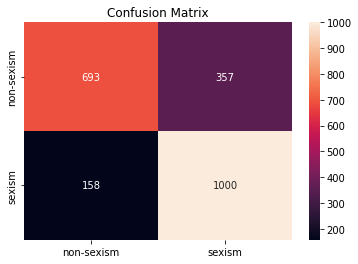

In [ ]:
result, model_outputs, wrong_predictions = model_bertweet_task1_english.eval_model(test_data_english[['text','label-task-1']])
display_classification_stats(result)
result

In [ ]:
predictions, raw_outputs = model_bertweet_task1_english.predict(list(test_data_english.text.values))

  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
print('Accuracy on Test Data:', accuracy_score(test_data_english['label-task-1'],predictions))
print('F1-Score on Test Data:', f1_score(test_data_english['label-task-1'],predictions))
print('Confusion Matrix on Test Data:\n', confusion_matrix(test_data_english['label-task-1'],predictions))
print('Classification on Test Data:\n', classification_report(test_data_english['label-task-1'],predictions))

## Task 2

In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/sexism_detection/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/sexism_detection/EXIST2021_test_labeled.tsv", sep="\t")

train_data = train_data[train_data.task2 != 'non-sexist']
test_data = test_data[test_data.task2 != 'non-sexist']

d = {
    'ideological-inequality'       : 0,         
    'misogyny-non-sexual-violence' : 1,    
    'objectification'              : 2,   
    'sexual-violence'              : 3,   
    'stereotyping-dominance'       : 4   
}

train_data = train_data.replace({"task2": d})
test_data = test_data.replace({"task2": d})

train_data_english = train_data[train_data.language != 'es']
test_data_english = test_data[test_data.language != 'es']

train_data_english = train_data_english.drop(["test_case", "source", "language", "id", "task1"], axis = 1)
test_data_english = test_data_english.drop(["test_case", "source", "language", "id", "task1"], axis = 1)

train_data_english.text = preprocessData(train_data_english.text)
test_data_english.text = preprocessData(test_data_english.text)

In [ ]:
model_bertweet_task2_english = ClassificationModel( 'bertweet', 'vinai/bertweet-base',num_labels=5, weight=[1, 1.35915493, 1.5078125, 1.12209302, 1.0546448], args={'train_batch_size':8,'learning_rate': 4e-5, 'num_train_epochs': 3, 'max_seq_length': 128, 'overwrite_output_dir': True})

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [ ]:
model_bertweet_task2_english.train_model(train_data_english)

/ssd_scratch/cvit/doltonfernandes/envs/myEnv/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1636 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/205 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/205 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/205 [00:00<?, ?it/s]

(615, 0.9361146432960906)

In [ ]:
def display_classification_stats_task2(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    target_names = ['ideological\ninequality', 'misogyny\nnon-sexual\nviolence', 'objectification', 'sexual\nviolence', 'stereotyping\ndominance' ]
    target_names2 = ['ideological inequality', 'misogyny non-sexual violence', 'objectification', 'sexual violence', 'stereotyping dominance' ]
    print(classification_report(y_true, y_pred, target_names=target_names2))
    plt.figure(figsize = (15,10))
    ax= plt.subplot()
    sns.heatmap(cf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(target_names,rotation=0, fontsize="17")
    ax.yaxis.set_ticklabels(target_names, rotation=0, fontsize="17")

In [ ]:
predictions_en2, raw_outputs = model_bertweet_task2_english.predict(list(train_data_english.text.values))

  0%|          | 0/1636 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

                              precision    recall  f1-score   support

      ideological inequality       0.93      0.93      0.93       386
misogyny non-sexual violence       0.80      0.81      0.81       284
             objectification       0.81      0.84      0.82       256
             sexual violence       0.89      0.89      0.89       344
      stereotyping dominance       0.87      0.85      0.86       366

                    accuracy                           0.87      1636
                   macro avg       0.86      0.86      0.86      1636
                weighted avg       0.87      0.87      0.87      1636



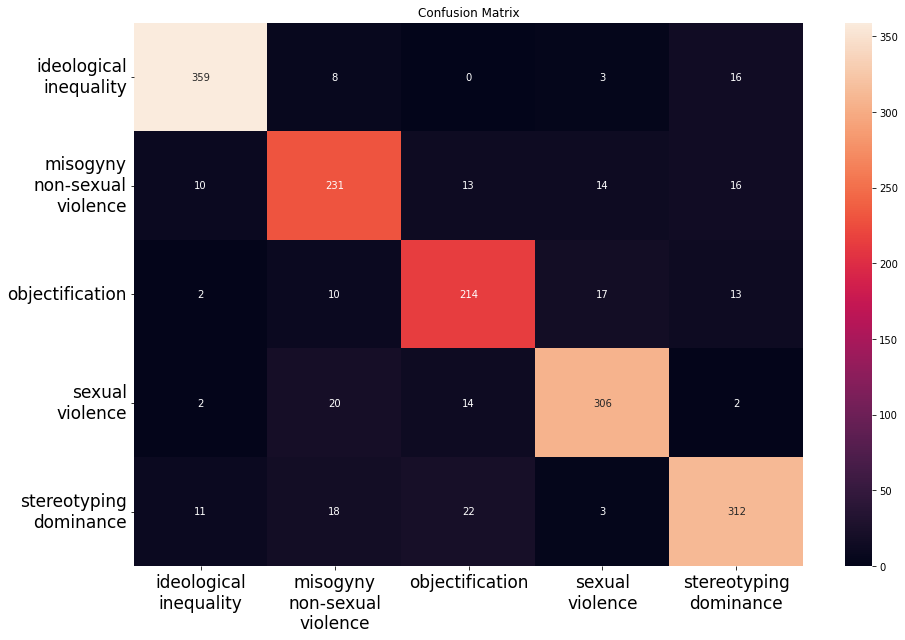

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
y_true = train_data_english.task2.values
y_pred = predictions_en2
display_classification_stats_task2(y_true, y_pred)

In [ ]:
predictions_en2, raw_outputs = model_bertweet_task2_english.predict(list(test_data_english.text.values))

  0%|          | 0/1158 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

                              precision    recall  f1-score   support

      ideological inequality       0.78      0.70      0.74       333
misogyny non-sexual violence       0.57      0.53      0.55       215
             objectification       0.55      0.57      0.56       150
             sexual violence       0.66      0.74      0.70       198
      stereotyping dominance       0.63      0.67      0.65       262

                    accuracy                           0.65      1158
                   macro avg       0.64      0.64      0.64      1158
                weighted avg       0.66      0.65      0.65      1158



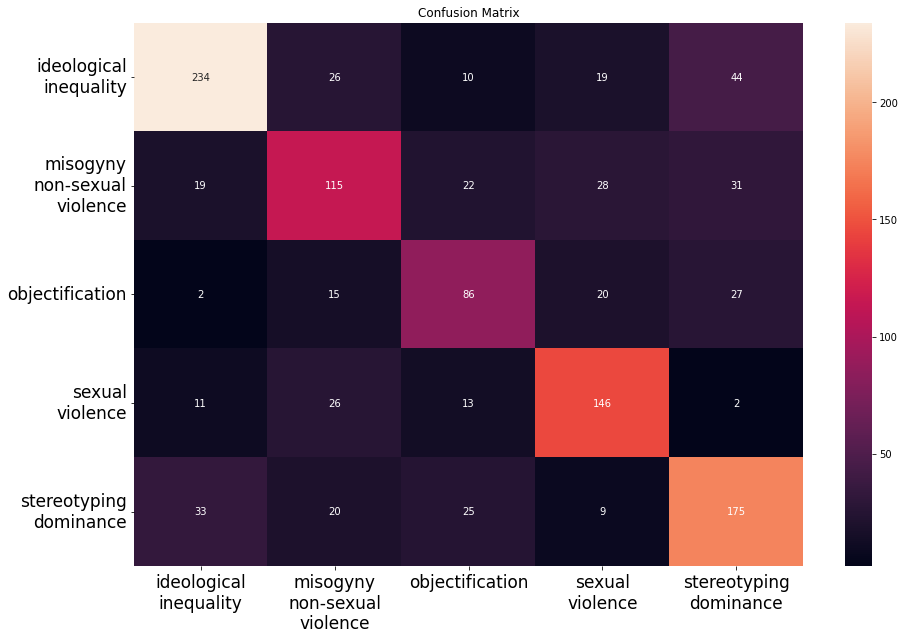

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
y_true = test_data_english.task2.values
y_pred = predictions_en2
display_classification_stats_task2(y_true, y_pred)